In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
from unidecode import unidecode
import spacy
from spacy.lang.fr import French
from spacy.lang.fr import stop_words as spacy_stopwords
import string
from tqdm import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()

In [3]:
mails = pd.read_csv('mails.csv', index_col = 0, encoding='UTF-16', header=0, skipinitialspace=True, skip_blank_lines = True)
mails['text'] = mails[['header', 'body']].astype(str).agg(' '.join, axis=1)
print(mails.shape)
mails.head()

(3407, 7)


,body,header,date,from,to,label,text
0,yohan quand tu as le temps dis moi si c est cl...,1ère relecture gt conso,"Fri, 29 May 2020 16:53:04 +0200",plonquet nadège,NaN,0,1ère relecture gt conso yohan quand tu as le t...
1,pour accepter la demande cliquez simplement su...,accepter,"Mon, 16 Sep 2019 17:09:37 +0200",plonquet nadège,NaN,0,accepter pour accepter la demande cliquez simp...
2,bonjour pouvez vous donner les accès à decibel...,acces decibel,"Tue, 23 Mar 2021 13:44:07 +0100",guillaume veronique,NaN,1,acces decibel bonjour pouvez vous donner les a...
3,comme ça ne fonctionne toujours pas sur mon po...,accès rec4 decibel sdw rec4 hm dm ad restituti...,"Mon, 24 Feb 2020 14:28:57 +0100",gueniot bernard,NaN,1,accès rec4 decibel sdw rec4 hm dm ad restituti...
4,tu sais ce que c est que ces actes qui n ont p...,actes indemnités hospitalières,"Mon, 25 Mar 2019 11:25:36 +0100",levisse xavier,NaN,1,actes indemnités hospitalières tu sais ce que ...


In [26]:
nlp = spacy.load("fr_core_news_md")
stop_words = spacy_stopwords.STOP_WORDS
punctuations = string.punctuation

In [27]:
bonjour = nlp("bonjour")
bonjour.vector.shape

(300,)

In [28]:
def tokenize(sentence):
    sentence = nlp(sentence)
    # lemmatizing
    sentence = [unidecode(word.lemma_.lower()).strip() if word.lemma_ != "-PRON-" else word.lower_ for word in sentence ]
    # removing stop words
    sentence = [ word for word in sentence if word not in stop_words and word not in punctuations]        
    return sentence

In [ ]:
sentences = mails.text.progress_apply(tokenize)
sentences

In [63]:
pd.to_pickle(sentences, 'mails_embedded.pkl')

In [10]:
vocab = set()
for s in sentences:
    vocab.update(set(s))
print(len(vocab))

10820


In [11]:
vectors=[]
for token in tqdm(vocab):
    vectors.append(nlp(token).vector)

100%|██████████| 10820/10820 [00:32<00:00, 334.14it/s]


## Représentation des mots

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(vectors)

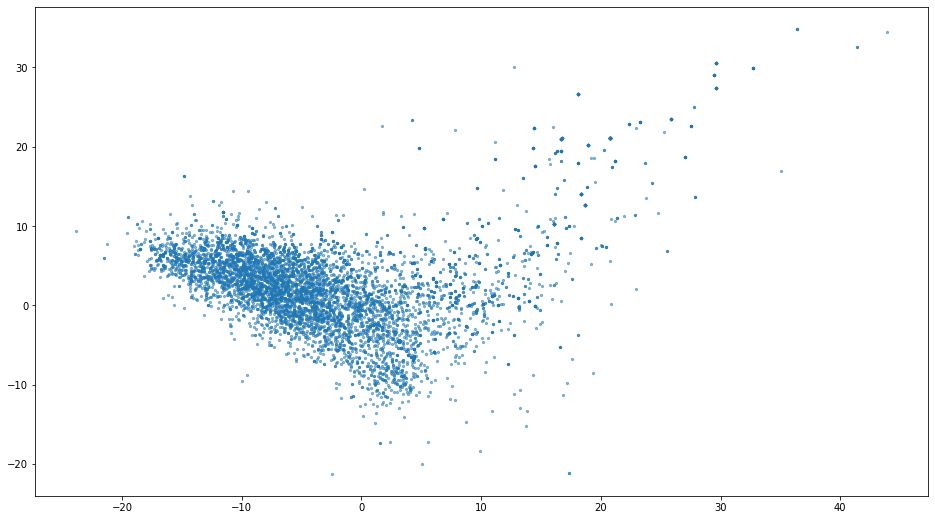

In [13]:
fig = plt.figure(figsize=(16, 9))

x_axis = embeddings_2d[:, 0]
y_axis = embeddings_2d[:, 1]

plt.scatter(x_axis, y_axis, s=5, alpha=0.5) # alpha for transparency
plt.show()

## Apprentissage semi-supervisé

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

plt.style.use('ggplot')

#on cherche à maximiser le rappel de la classe 1

In [33]:
class SpacyEmbeddings(TransformerMixin): # it inherits the sklearn's base class for transformers
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [sentence.strip().lower() for sentence in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}
bow_vector = CountVectorizer(tokenizer=tokenize, ngram_range=(1,1))
tfidf_vector = TfidfVectorizer(tokenizer = tokenize)

In [51]:
X_unlabeled = mails[mails['label'] == 2]
X, y = mails[mails['label'] != 2], mails[mails['label'] != 2].label

In [44]:
from sklearn.tree import DecisionTreeClassifier
pipe = Pipeline([("embedder", SpacyEmbeddings()),
                 ('vectorizer', bow_vector),
                 ('classifier', DecisionTreeClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X.test, y, test_size=0.3)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

0.9231568016614745
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       835
           1       0.70      0.73      0.72       128

    accuracy                           0.92       963
   macro avg       0.83      0.84      0.84       963
weighted avg       0.92      0.92      0.92       963



In [41]:
from sklearn.linear_model import LogisticRegression
pipe = Pipeline([("embedder", SpacyEmbeddings()),
                 ('vectorizer', bow_vector),
                 ('classifier', LogisticRegression(solver = 'newton-cg'))])

X_train, X_test, y_train, y_test = train_test_split(X.test, y, test_size=0.3)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

0.9148494288681205
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       829
           1       0.73      0.61      0.67       134

    accuracy                           0.91       963
   macro avg       0.84      0.79      0.81       963
weighted avg       0.91      0.91      0.91       963



### Prédiction des labels manquants

In [52]:
estimator = Pipeline([("embedder", SpacyEmbeddings()),
                 ('vectorizer', bow_vector),
                 ('classifier', DecisionTreeClassifier())])  #SVC ou arbre

X_unlabeled_copy = X_unlabeled.copy()
newX = X
newY = y
threshold = 0.9
print(newX.shape, X_unlabeled_copy.shape)
while not X_unlabeled_copy.empty:

    estimator.fit(newX.text, newY)
    y_pred = estimator.predict(X_unlabeled_copy.text)
    y_prob = estimator.predict_proba(X_unlabeled_copy.text)
    X_unlabeled_copy['_pred_'] = y_pred
    X_unlabeled_copy['_prob_'] = [y_prob[k,y_pred[k]] for k in range(len(y_pred))]
    confident_pred = X_unlabeled_copy[X_unlabeled_copy['_prob_'] >= threshold]
    X_unlabeled_copy = X_unlabeled_copy[X_unlabeled_copy['_prob_'] < threshold].drop(['_pred_', '_prob_'], axis = 1)
    newX = pd.concat([newX, confident_pred.drop(['_pred_', '_prob_'], axis = 1)], ignore_index = True)
    newY = pd.concat([newY, confident_pred['_pred_']], ignore_index = True)
    print(newX.shape, X_unlabeled_copy.shape, threshold)

    if len(confident_pred)==0:
        break

(3210, 7) (197, 7)
(3407, 7) (0, 7) 0.9


# Catégorisation des mails

In [60]:
from sklearn.tree import DecisionTreeClassifier
pipe = Pipeline([("embedder", SpacyEmbeddings()),
                 ('vectorizer', bow_vector),
                 ('classifier', DecisionTreeClassifier())])

X_train, X_test, y_train, y_test = train_test_split(newX.text, newY, test_size=0.3)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

0.9002932551319648
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       864
           1       0.67      0.70      0.69       159

    accuracy                           0.90      1023
   macro avg       0.81      0.82      0.81      1023
weighted avg       0.90      0.90      0.90      1023



In [ ]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(newX.text, newY, test_size=0.3)
pipe = Pipeline([("embedder", SpacyEmbeddings()),
                 ('vectorizer', bow_vector),
                 ('classifier', SVC(class_weight='balanced'))])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

In [67]:
X_train, X_test, y_train, y_test = train_test_split(newX.text, newY, test_size=0.3)
pipe = Pipeline([("embedder", SpacyEmbeddings()),
                 ('vectorizer', bow_vector),
                 ('classifier', LogisticRegression(solver = 'newton-cg'))])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

0.9110459433040078
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       882
           1       0.67      0.70      0.69       141

    accuracy                           0.91      1023
   macro avg       0.81      0.82      0.82      1023
weighted avg       0.91      0.91      0.91      1023



## Optimisation des modèles

In [48]:
import pickle
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(newX, newY, test_size=0.3)

gridCV = GridSearchCV(SVC(),
    n_jobs=-1,
    param_grid = {
        'C' : [0.1325],
        'kernel' : ['linear'],
        #'degree' : [1, 2, 3, 4],
        #'gamma' : ['scale', 'auto'] + list(np.linspace(0,2,3)),
        #'coef0' : np.linspace(-2,2,5),
        'class_weight' : ['balanced', None],
        #'decision_function_shape' : ['ovo', 'ovr']
    }
)

gridCV.fit(X_train, y_train)
print(gridCV.best_params_)
print(gridCV.best_score_)
#{'C': 0.1325, 'class_weight': None, 'kernel': 'linear'}

{'C': 0.1325, 'class_weight': None, 'kernel': 'linear'}
0.9192010235179116


In [105]:
model_svc = SVC(C=0.1325, kernel = 'linear')
model_svc.fit(X_train, y_train)
y_pred = model_svc.predict(X_test)
accuracy_score(y_test, y_pred)

0.9105691056910569

In [ ]:
filename = 'svc_c01325_lin.sav'
with open(filename, 'wb') as file:
    pickle.dump(model_svc, file)

In [ ]:
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(newX, newY, test_size=0.3)

gridCV2 = GridSearchCV(LogisticRegression(),
    n_jobs=-1,
    param_grid = {
'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
'dual' : [False, True],
'C' : np.linspace(0.0001,3, 10),
'fit_intercept' : [True, False],
'class_weight' : [None, 'balanced'],
'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
'warm_start' : [True],
'l1_ratio' : [0, 0.5, 1]
    }
)

gridCV2.fit(X_train, y_train)
print(gridCV2.best_params_)
print(gridCV2.best_score_)
#{'C': 0.3334222222222222, 'class_weight': None, 'dual': False, 'fit_intercept': False, 'l1_ratio': 0, 'penalty': 'l1', 'solver': 'liblinear', 'warm_start': True}
#0.91

In [24]:
X_train, X_test, y_train, y_test = train_test_split(newX, newY, test_size=0.3)
LR = LogisticRegression(C = 0.3334222222222222, class_weight = None, dual = True, fit_intercept = False, 
                        solver = 'liblinear', warm_start = True)
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
accuracy_score(y_test, y_pred)

C:\Users\le_paumier-m\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.9196337741607324

In [116]:
filename = 'lr_c033_liblinear_dual.sav'
with open(filename, 'wb') as file:
    pickle.dump(LR, file)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
LR = LogisticRegression(C = 0.3334222222222222, class_weight = None, dual = True, fit_intercept = False, 
                        solver = 'liblinear', warm_start = True)
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
accuracy_score(y_test, y_pred)

C:\Users\le_paumier-m\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.9116080937167199

Sur ces méthodes de machine learning classique, l'extension du dataset à partir des données non-labellisées ne produit pas une grande amélioration des performances, ce sera plus flagrant lorsqu'on passera à des méthodes de Deep Learning

## Prédiction des probabilités

In [117]:
np.round(LR.predict_proba(newX),2)

array([[0.99, 0.01],
       [0.78, 0.22],
       [0.14, 0.86],
       ...,
       [0.94, 0.06],
       [0.98, 0.02],
       [0.66, 0.34]])